# Setup of burner combustion conditions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]

In [2]:
from majordome.simulate import HydrocarbonHeatingValue
from majordome.simulate import BurnerFlowRatesCalculator
from majordome.simulate import CombustorPSR
from majordome.units.flow_units import FlowUnits

import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd
import utilities.nb015 as nbu

Add database directory to Cantera's path.

In [3]:
ct.add_directory("../databases/kinetics/")

## Energy release study

Set general parameters (see comments) to use in estimations.

In [4]:
# All base estimations are performed with benchmark mechanism Gri-Mech 3.0
mech = "gri30.yaml"

# For combustion we aim a slightly reducing atmosphere composition.
phi = 0.993

# Nominal power to be computed in terms of HHV.
hdot = 586.0

In what follows, evaluation of heating capacities is evaluated using `HydrocarbonHeatingValue` class implemented by `majordome` package.

To validate the generalized implementation, one may confront the following results to the ones in the [reference](https://cantera.org/examples/jupyter/thermo/heating_value.ipynb.html) example provided by Cantera.

In [5]:
hcv = HydrocarbonHeatingValue(gas=ct.Solution(mech))

lhv, hhv = hcv.heating_values("CH4: 1", "O2: 1")
lhv, hhv = lhv / 1000, hhv / 1000

print(f"LHV = {lhv:.3f} MJ/kg HHV = {hhv:.3f} MJ/kg")

LHV = 50.025 MJ/kg HHV = 55.510 MJ/kg


Select a fuel and oxidizer as defined in `utilities.nb015` module under this directory.

A few options with allowed composition sets names is provided as commented out lines.

In [6]:
# fuel, oxid = nbu.get_chemistry_set("pure_methane", "air")
# fuel, oxid = nbu.get_chemistry_set("pure_methane", "pure_oxygen")
# fuel, oxid = nbu.get_chemistry_set("natural_gas_basic", "pure_oxygen")
# fuel, oxid = nbu.get_chemistry_set("natural_gas_real", "air")
fuel, oxid = nbu.get_chemistry_set("natural_gas_real", "pure_oxygen_humid")
fuel, oxid

({'CH4': 0.9219, 'C2H6': 0.0427, 'C3H8': 0.0064, 'CO2': 0.0095, 'N2': 0.0195},
 {'O2': 0.995, 'H2O': 0.005})

In [7]:
hcv = HydrocarbonHeatingValue(gas=ct.Solution(mech))

# Using private method to check uncorrected value.
lhv, hhv = hcv._heating_values(fuel, oxid)
lhv, hhv = lhv / 1000, hhv / 1000

print(f"LHV = {lhv:.3f} MJ/kg HHV = {hhv:.3f} MJ/kg")

lhv, hhv = hcv.heating_values(fuel, oxid)
lhv, hhv = lhv / 1000, hhv / 1000

print(f"LHV = {lhv:.3f} MJ/kg HHV = {hhv:.3f} MJ/kg")

LHV = 49.765 MJ/kg HHV = 55.165 MJ/kg
LHV = 46.994 MJ/kg HHV = 52.094 MJ/kg


The next step is to determine the required mass flow rate required to match the reference power based on gas heating value.

Class `BurnerFlowRatesCalculator` computes the relative amounts of fuel and oxidizer to match required power and then evaluate required flow rate.

Since `HydrocarbonHeatingValue` scales the heating values assuming $H_2$ and hydrocarbons in fuel only, the actual LHV/HHV are correct to match the content of those species in the provided fuel composition by `BurnerFlowRatesCalculator` if a user supplied capacity is not provided.

In [8]:
fcalc = BurnerFlowRatesCalculator(mech)
fcalc.set_states(phi, fuel, oxid, basis="mole")

# fuel_ndot, oxid_ndot = fcalc.get_mole_flow_from_fuel_flow(1.0)
fuel_ndot, oxid_ndot = fcalc.get_mole_flow_rates(hdot, method="LHV")
fuel_mdot, oxid_mdot = fcalc.mole_to_mass_flow(fuel_ndot, oxid_ndot)

vol_flow_ratio = oxid_ndot / fuel_ndot
mixt_mdot = fuel_mdot + oxid_mdot

Corrected LHV = 10.9 kWh/Nm³


Using the computed mass flow rate, a single chamber combustion is evaluated at steady state.

Both heat release rate and change in material enthalpy are retrieved.

In [9]:
comb = CombustorPSR(mech)
comb.set_states(phi, fuel, oxid, basis="mole")
comb.simulate_with_mass_flow(mixt_mdot)

rdot = comb.states.heat_release_rate[0] / 1000

print(f"""
Volume flow ratio .......... {vol_flow_ratio:.2f}
Fuel flow rate ............. {fuel_mdot*3600:.1f} kg/h
Oxidizer flow rate ......... {oxid_mdot*3600:.1f} kg/h
Mixture flow rate .......... {mixt_mdot*3600:.1f} kg/h
Heat release rate .......... {rdot:.1f} kW
""")


Volume flow ratio .......... 2.05
Fuel flow rate ............. 40.9 kg/h
Oxidizer flow rate ......... 154.6 kg/h
Mixture flow rate .......... 195.5 kg/h
Heat release rate .......... 294.6 kW



In [10]:
show_species = ["CH4", "O2", "H2O", "CO2", "CO"]
show_species = [f"X_{s}" for s in show_species]

quantities = ["heat_release_rate", "T", "X"]
where = [*quantities[:2], *show_species]

df = comb.states.to_pandas(quantities).T.loc[where]
df.loc[show_species] *= 100
df.loc["heat_release_rate"] /= 1000

df

,0
heat_release_rate,2.945673e+02
T,3.045959e+03
X_CH4,6.770716e-07
X_O2,8.505310e+00
X_H2O,3.884628e+01
X_CO2,1.163840e+01
X_CO,1.559933e+01


## Evaluation of residence time role in combustor

In [11]:
tau_max = 0.01

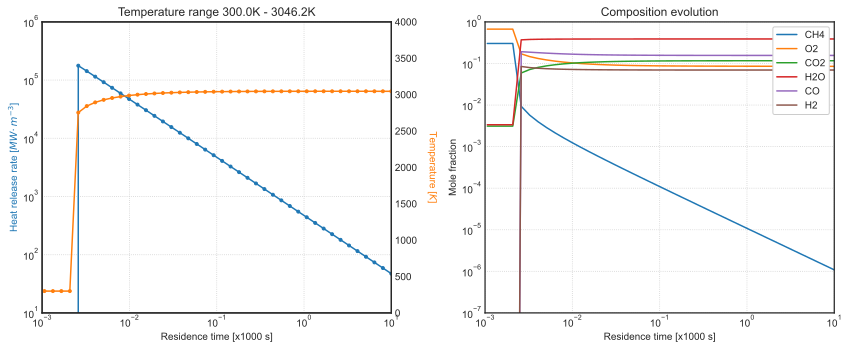

In [12]:
comb = nbu.test_gri30(mech, phi, fuel, oxid, tau_max)

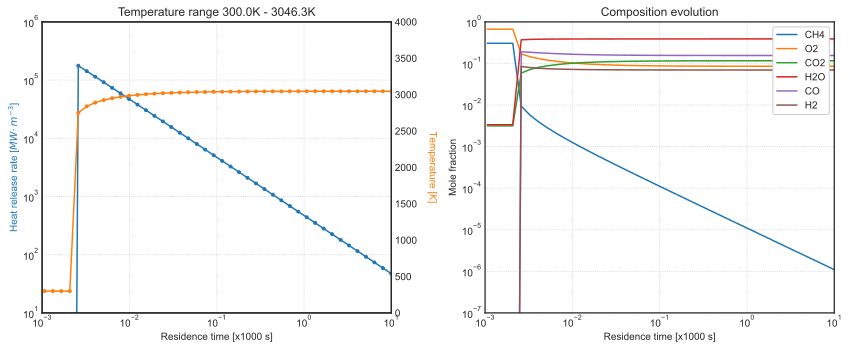

In [13]:
comb = nbu.test_lu30_gri30(mech, phi, fuel, oxid, tau_max)

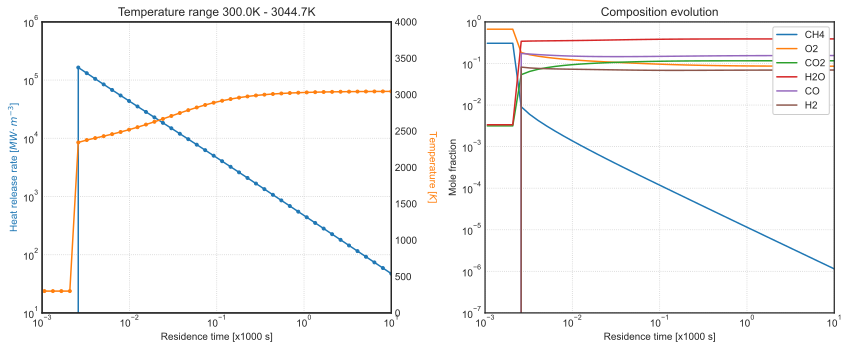

In [14]:
comb = nbu.test_zhukov23_gri30(mech, phi, fuel, oxid, tau_max)

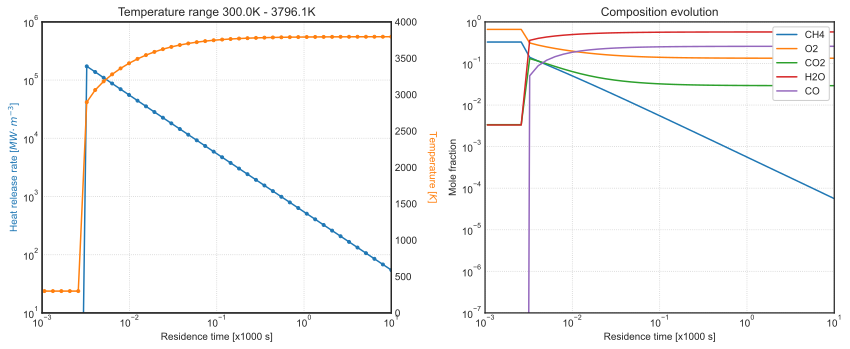

In [15]:
comb = nbu.test_2s_ch4_bfer(mech, phi, fuel, oxid, tau_max)